## Student ID: 190428550

### Machine Learning and Neural Networks - Template (1)
### Deep Learning on a Public Dataset

##### *This notebook will contain the third iteration of our project, where we will attempt to create a well performing model using the Keras Functional API. We will also be applying batch normalization in our Keras Functional API model. This is a continuation of the 2nd iteration. Any new findings will be reported in new sections.*


### Table of Contents

[Introduction](#introduction) <br>
[Methodology](#methodology) <br>
[Results](#results) <br>
[Conclusion](#conclusion)<br>
[References](#references)

### 1. Define the problem and assemble the dataset

The delay of flights will be predicted in this assignment. The data is obtained from Harvard Dataverse and converted into a CSV format for accessibility.

The data contained in this dataset contains columns which are redundant for the exploration of our topic. The columns that will be used as our input to predict flight delays are:

Categorical features:

Month - Month
Day Of Week - Day of Week
UniqueCarrier - Unique Carrier
Origin - Origin airport
Dest - Destination airport
HourOfDay - Hour(24H format) based on scheduled departure time (CRSDepTime)
Numerical feature:

Distance - Distance between airports (miles)
This problem type falls under binary classification as there are only two outputs: Delayed / Not delayed

According to the Bureau of Transportation Statistics, flights that arrive or depart 15 minutes after the scheduled time are considered delayed. Conversely, if a flight arrives or departs within 15 minutes of the scheduled time, it will be considered to be on time.

A target variable column, 'Delayed', will be created which takes integer 1 or 0. Delayed = 1 if ArrDelay exceeds 15 minutes and 0 otherwise.

Problems that may arise given the dataset used:

The dataset only contains the records from the year of 2007. The latest dataset available is from 2008, but only contains the first 4 months of 2008. Hence, the dataset for 2007 was chosen and it is the lastest and most complete.

Although a full range of data is available from 1987 to 2007, only data from the year 2007 will be used for this assigment due to computational limitations. 2007.csv contains more than 7 million rows on its own and takes more than 7 hours to train the model once. Although this is the lastest dataset available, it may not be able to predict current data accurately as the data is more than a decade old. We will be making the assumption that the future will behave like the past.

### 2. Choosing a measure of success

Accuracy metric was initially chosen to gauge our success levels. However, it was found that it does not provide an accurate representation of the model's success. Based on the dataset, an average of 78% of flights are on time and 22% are delayed. Since the data is imbalanced in this case, accuracy cannot be used as the measure of success as it may produce a biassed result.

We will be using ROC AUC and F1 score to gauge the level of success.

### 3. Deciding on an evaluation protocol (Testing)


The model will be evaluated using hold-out validation as we have a large number of data to utilise. The dataset will be split into ‘train’ and ‘test’ sets to evaluate how well the model works on data that has not yet been seen. The training set will be used to train the model. When employing the hold-out method, a typical split is to use 80% of the data for training and the remaining 20% for testing. A confusion matrix will be used to summarise the performance of the classifier.


### 4. Preparing your data

To prepare the data for training, vectorization will be performed on the values in the dataset. The dataset is made up of strings and integers. One-hot encoding must be used on the strings to convert them into a tensor of float32 data for TensorFlow to accept. Furthermore, the data will need to be normalised so that the network can converge. The values will be adjusted by ratio into the range 0-1. The features will also be normalised so that they have a mean of 0 and a standard deviation of 1. The dataset will be examined for invalid or missing values.


In [2]:
# pip install tensorflow
# pip install keras
# pip install pydot
# install graphviz

In [3]:
import pandas as pd
import numpy as np
import os

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras

In [4]:
tf.__version__

'2.9.0-dev20220304'

In [5]:
# read in data from csv, extract 100k samples
# processing data from the other columns

airplane_data = pd.read_csv("2007.csv")
airplane_data = airplane_data.sample(n=100000)

airplane_data['CRSDepTime'].isna().sum() # There are no NA's

airplane_data['CRSDepTime'] = airplane_data['CRSDepTime'].astype(str)
length_of_crsdeptime = airplane_data['CRSDepTime'].str.len()
airplane_data['HourOfDay'] = np.select([length_of_crsdeptime==4, length_of_crsdeptime==3, length_of_crsdeptime<3], [airplane_data['CRSDepTime'].str[0:2], airplane_data['CRSDepTime'].str[0:1], 0], np.nan)
airplane_data['HourOfDay'] = airplane_data['HourOfDay'].astype(int)

In [6]:
# adding a column to determine if flight was delayed based on the arrival delay time

airplane_data = airplane_data.copy()
airplane_data['Delayed'] = np.where(airplane_data['ArrDelay'] > 15, 1, 0) # Creating 'Delayed' column. Delayed = 1 if ArrDelay exceeds 15 minutes, 0 otherwise. 
airplane_data = airplane_data[['Month', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'HourOfDay', 'Delayed']] # Keeping only columns that will be used as features and target variable.

In [7]:
airplane_data.head()

,Month,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,HourOfDay,Delayed
6710295,11,4,AA,JFK,SFO,2586,17,0
5038074,9,4,WN,IAD,LAS,2066,12,0
4393127,8,3,WN,DAL,AUS,189,17,0
3574222,6,2,AA,DFW,PHL,1302,8,1
4539617,8,5,OO,RFD,DEN,829,13,0


In [8]:
dataframe = airplane_data

### Split the dataset into training, validation and testing sets, 80:10:10 ratio

In [9]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [10]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

80000 training examples
10000 validation examples
10000 test examples


### Creating an input pipline using tf.data

In [11]:
# Convert training, validation and testing sets dataframe into tf.data.Dataset
# Shuffles and batches data

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    
    df = dataframe.copy()
    labels = df.pop('Delayed')
    df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
        ds = ds.prefetch(batch_size)
        return ds

In [12]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [13]:
# Checking if the function returned a dictionary of column names that maps column values and rows

[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of month:', train_features['Month'])
print('A batch of delayed:', label_batch )

Every feature: ['Month', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'HourOfDay', 'Delayed']
A batch of month: tf.Tensor(
[[ 7]
 [12]
 [ 2]
 [ 7]
 [ 9]], shape=(5, 1), dtype=int64)
A batch of delayed: tf.Tensor([0 1 0 0 0], shape=(5,), dtype=int32)


### Recap on selected features

Categorical features: 
* Month - Month
* Day Of Week - Day of Week 
* UniqueCarrier - Unique Carrier
* Origin - Origin airport 
* Dest - Destination airport Airports not in the top 100  will be categorized as Others
* HourOfDay - Hourly interval based on scheduled departure time (CRSDepTime)

Numerical feature:
* Distance - Distance between airports (miles)

#### Numerical Columns

Standardizing the distribution of data by using normalization for each numeric feature. In this case, distance only.

In [14]:
def get_normalization_layer(name, dataset):
    
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)
    
    return normalizer

In [15]:
# Test the function with 'Distance' feature

dist_col = train_features['Distance']
layer = get_normalization_layer('Distance', train_ds)
layer(dist_col)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.895],
       [-0.673],
       [-0.059],
       [-0.822],
       [-0.698]], dtype=float32)>

#### Categorical Columns

Categorical features need to be multi-hot encoded before it can be fed to the model.
The function below returns a layer that maps values from a vocabulary to integer indices using StringLookup or IntegerLookup.

In [16]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    
    # Create a layer that turns strings into integer indices.
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Encode the integer indices.
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    # Apply multi-hot encoding to the indices.
    return lambda feature: encoder(index(feature))

In [17]:
# Testing the previous function on categorical strings features

test_carrier_col = train_features['UniqueCarrier']
test_carrier_layer = get_category_encoding_layer(name='UniqueCarrier',
                                              dataset=train_ds,
                                              dtype='string')
test_carrier_layer(test_carrier_col)

<tf.Tensor: shape=(5, 21), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]], dtype=float32)>

In [18]:
test_origin_col = train_features['Origin']
test_origin_layer = get_category_encoding_layer(name='Origin',
                                              dataset=train_ds,
                                              dtype='string')
test_origin_layer(test_origin_col)

<tf.Tensor: shape=(5, 296), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [19]:
test_dest_col = train_features['Dest']
test_dest_layer = get_category_encoding_layer(name='Dest',
                                              dataset=train_ds,
                                              dtype='string')
test_dest_layer(test_dest_col)

<tf.Tensor: shape=(5, 297), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [20]:
# Testing the previous function using categorical integer features

month_col = train_features['Month']
month_layer = get_category_encoding_layer(name='Month',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
month_layer(month_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

In [21]:
day_col = train_features['DayOfWeek']
day_layer = get_category_encoding_layer(name='DayOfWeek',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
day_layer(day_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [22]:
hour_col = train_features['HourOfDay']

hour_layer = get_category_encoding_layer(name='HourOfDay',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
hour_layer(hour_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

### Preprocessing selected features to train the model

Preprocessing will be applied on all the selected features and then added to a list.

In [23]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, batch_size=batch_size)
test_ds = df_to_dataset(test, batch_size=batch_size)

Normalizing the numerical features **Distance**, and add it to one list of inputs called encoded_features:

In [24]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in ['Distance']:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

Turn the integer categorical values from the dataset **Month, DayOfWeek, HourOfDay** into integer indices, perform multi-hot encoding, and add the resulting feature inputs to encoded_features:

In [25]:
month_col = tf.keras.Input(shape=(1,), name='Month', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Month',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_month_col = encoding_layer(month_col)
all_inputs.append(month_col)
encoded_features.append(encoded_month_col)

In [26]:
day_col = tf.keras.Input(shape=(1,), name='DayOfWeek', dtype='int64')

encoding_layer = get_category_encoding_layer(name='DayOfWeek',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_day_col = encoding_layer(day_col)
all_inputs.append(day_col)
encoded_features.append(encoded_day_col)

In [27]:
hour_col = tf.keras.Input(shape=(1,), name='HourOfDay', dtype='int64')

encoding_layer = get_category_encoding_layer(name='HourOfDay',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_hour_col = encoding_layer(hour_col)
all_inputs.append(hour_col)
encoded_features.append(encoded_hour_col)

Repeating the same steps for categorical features

In [28]:
# categorical features.

categorical_cols = ['UniqueCarrier', 'Origin', 'Dest']

for header in categorical_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

### Create, Compile and Train a Model (Using Keras Functional API)

The model will be created using Keras Functional API. The first layer merges all feature inputs using concatenation.

In [29]:
from keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense

In [30]:
all_features = tf.keras.layers.concatenate(encoded_features)

x = tf.keras.layers.Dense(32)(all_features)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(16)(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(all_inputs, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Month (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 HourOfDay (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 UniqueCarrier (InputLayer)     [(None, 1)]          0           []                               
                                                                                              

### Configuring the model using compile

Binary crossentropy is selected as there are only two outcomes for the flight delay prediction: Delayed or Not Delayed.

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy", tf.keras.metrics.AUC(from_logits=True)])

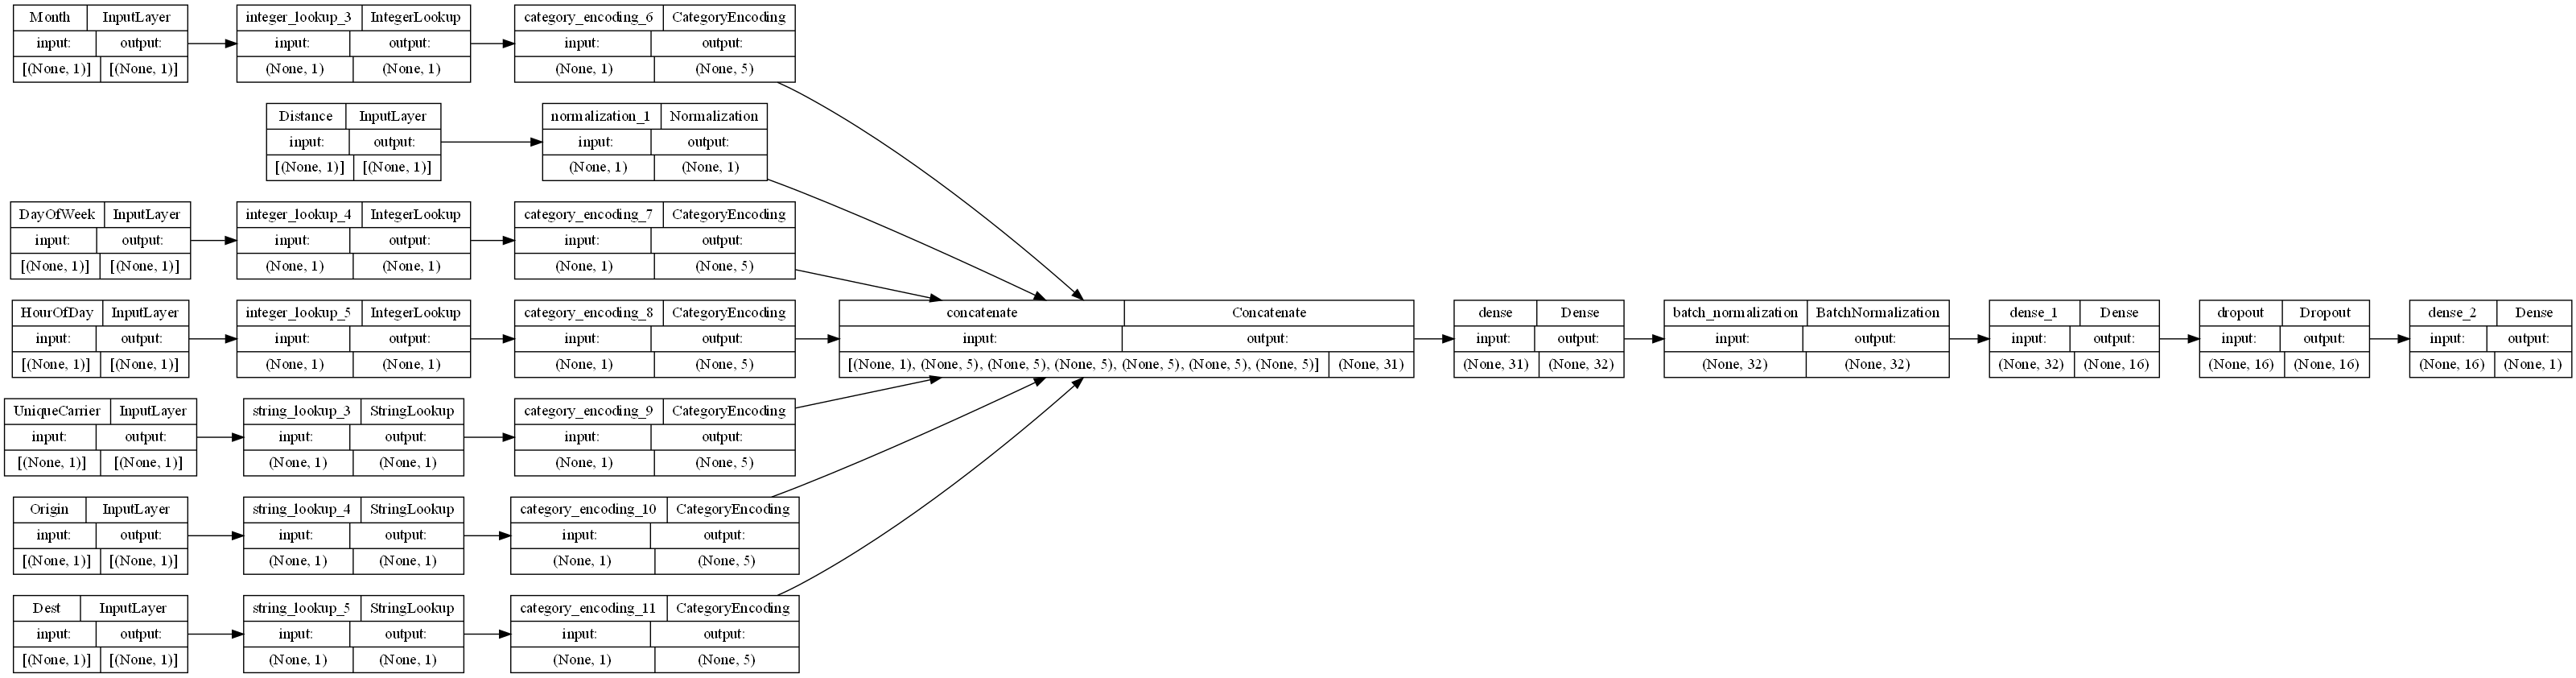

In [32]:
# Visualizing the connectivity graph

tf.keras.utils.plot_model(model, show_shapes=True, dpi=100, rankdir="LR")

### Training the Model

In [33]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
313/313 [==============================] - 3s 4ms/step - loss: 0.6061 - accuracy: 0.7068 - auc: 0.5433 - val_loss: 0.5276 - val_accuracy: 0.7709 - val_auc: 0.5986
Epoch 2/10
313/313 [==============================] - 1s 3ms/step - loss: 0.5422 - accuracy: 0.7655 - auc: 0.5764 - val_loss: 0.5285 - val_accuracy: 0.7710 - val_auc: 0.5977
Epoch 3/10
313/313 [==============================] - 1s 3ms/step - loss: 0.5377 - accuracy: 0.7667 - auc: 0.5840 - val_loss: 0.5279 - val_accuracy: 0.7709 - val_auc: 0.5942
Epoch 4/10
313/313 [==============================] - 1s 3ms/step - loss: 0.5354 - accuracy: 0.7669 - auc: 0.5893 - val_loss: 0.5272 - val_accuracy: 0.7709 - val_auc: 0.5990
Epoch 5/10
313/313 [==============================] - 1s 3ms/step - loss: 0.5338 - accuracy: 0.7671 - auc: 0.5918 - val_loss: 0.5281 - val_accuracy: 0.7708 - val_auc: 0.5935
Epoch 6/10
313/313 [==============================] - 1s 3ms/step - loss: 0.5328 - accuracy: 0.7671 - auc: 0.5944 - val_loss: 0.52

### Testing the Model

In [34]:
loss, accuracy, auc = model.evaluate(test_ds)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

40/40 [==============================] - 0s 2ms/step - loss: 0.5250 - accuracy: 0.7711 - auc: 0.6066
Loss:  0.5249856114387512
AUC:  0.6066322326660156
Accuracy:  0.7710999846458435


### Visualizing the validation loss and validation accuracy graphs

In [35]:
# Create function to plot graphs

import matplotlib.pyplot as plt

def plot_loss(loss, val_loss):
    plt.clf()
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_accuracy(acc, val_acc):
    plt.clf()
    epoch = range(1, len(acc) +1)
    plt.plot(epoch, acc, 'bo', label="Training Accuracy")
    plt.plot(epoch, val_acc, 'b', label="Validation Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    

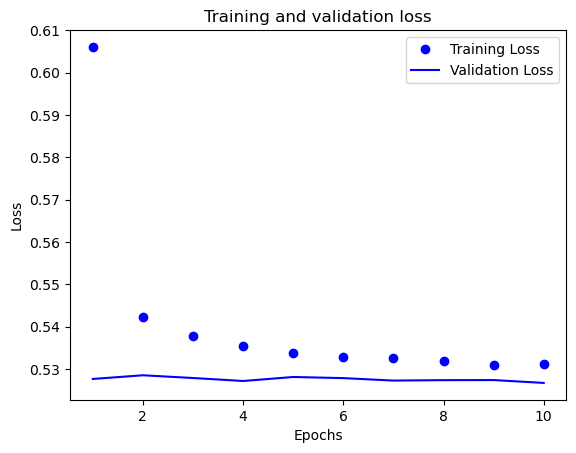

In [36]:
plot_loss(history.history['loss'], history.history['val_loss'])

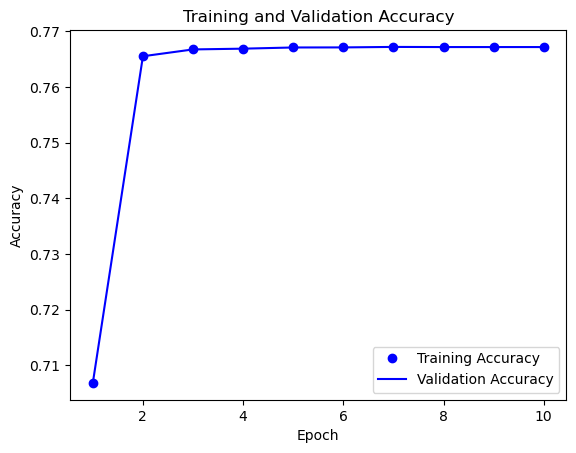

In [37]:
plot_accuracy(history.history['accuracy'], history.history['accuracy'])

### Saving and Reloading the Keras Model

In [38]:
model.save('flight_delay_classifier_first')
reloaded_model = tf.keras.models.load_model('flight_delay_classifier_first')

INFO:tensorflow:Assets written to: flight_delay_classifier_first\assets


INFO:tensorflow:Assets written to: flight_delay_classifier_first\assets


### Getting a Prediction on a Sample

The model can be implemented to flight booking websites or apps and inputs the flight details so that passengers determine the probability of a flight being delayed.

In [39]:
# EXAMPLE

sample = {
    'Month': 5,
    'DayOfWeek': 5,
    'UniqueCarrier': 'MQ',
    'Origin': 'TVC',
    'Dest': 'ORD',
    'Distance': 224,
    'HourOfDay': 12,    
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = reloaded_model.predict(input_dict)
prob = tf.nn.sigmoid(predictions[0])

print(
    "This particular flight had a %.1f percent probability "
    "of getting delayed." % (100 * prob)
)

1/1 [==============================] - 0s 249ms/step
This particular flight had a 58.6 percent probability of getting delayed.


# Whats Next?

In the next iteration, we will be working on creating a model using **Model Ensembling**, which is part of the advanced modelling technique found in Chapter 7 of 'Deep Learning with Python' by François Chollet.